In [69]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [70]:
llm.invoke("Hi").content

'Hi! 👋 \n\nWhat can I do for you today? 😊\n'

In [71]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [72]:
def call_model(state: MessagesState): #state - user input
    messages = state['messages'] #fetch the user input
    response = llm.invoke(messages) #pass the user input to the llm
    return {"messages": [response]} 

In [73]:
#Let's create a workflow
workflow = StateGraph(MessagesState) #workflow with state graph
#Add node
workflow.add_node("CHATBOT",call_model)
#Add edge
workflow.add_edge(START,"CHATBOT")
workflow.add_edge("CHATBOT",END)

app = workflow.compile()


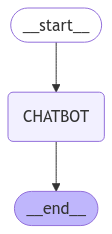

In [74]:
#Visualize the workflow

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [75]:
input = {"messages": [HumanMessage("Hi, my name is Amar")]}

#or

#input = {"messages": ["Hi, my name is Amar"]}

In [76]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, my name is Amar', additional_kwargs={}, response_metadata={}, id='f5f65f62-e5e2-4792-880a-8d56efcb296a'),
  AIMessage(content="Hi Amar, it's nice to meet you! 👋\n\nWhat can I do for you today? 😊  \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 8.785e-05, 'queue_time': 0.021180868999999998, 'total_time': 0.047360577}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-34bdd9df-c54a-41e5-989a-2c7bb39c2af8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})]}

In [77]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node") #Key representing the node
        print("_______")
        print(value) #value representing the actual output
        print("\n") 

Output from CHATBOT Node
_______
{'messages': [AIMessage(content="Hi Amar, it's nice to meet you! 👋\n\nWhat can I do for you today? 😄\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 15, 'total_tokens': 40, 'completion_time': 0.045454545, 'prompt_time': 0.00011058, 'queue_time': 0.02275622, 'total_time': 0.045565125}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f2d2038c-bfd9-4ae3-a2ac-f778c4d64df8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 25, 'total_tokens': 40})]}




In [78]:
#Second Stage with architecture 2
# Here we are going to add the tools inside our solution

#Let's create a tool(Dummy tool)   
@tool
def search(query: str):
    """this is my custom tool."""
    if "ca" in query.lower() or "california" in query.lower():
        return "It's 20*C degrees and Cold."
    return "It's 40*C degrees and scootching heat."

In [79]:
search.invoke("what is the weather in CALIFORNIA?")

"It's 20*C degrees and Cold."

In [80]:
search.invoke("what is the weather in CA?")

"It's 20*C degrees and Cold."

In [81]:
search.invoke("what is the weather in ca?")

"It's 20*C degrees and Cold."

In [82]:
search.invoke("what is the weather in Texas?")

"It's 40*C degrees and scootching heat."

In [83]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001D558433C70>)

In [84]:
#Create the tool variable
tools = [search]

In [85]:
#Convert the tool to node
#tool_node = ToolNode("SEARCH",tools)

tool_node = ToolNode(tools)

In [86]:
#Let's bind our tool on top of the LLM and now our LLM will associated with our tool
llm_with_tool = llm.bind_tools(tools)

In [87]:
#Create the workflow
def call_model1(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages) #Here we pass the input to the llm_with_tool(llm ond our own tool)
    return {"messages": [response]}

In [88]:
response = call_model1({"messages": ["Hi,how are you?"]})

In [89]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1bca', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.030198098, 'queue_time': 0.023699412000000003, 'total_time': 0.179289007}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e362c83c-7d55-4951-a756-57fa1cf750d6-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_1bca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}

In [90]:
messages = response['messages']

In [91]:
last_message = messages[-1]

In [92]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'how are you'},
  'id': 'call_1bca',
  'type': 'tool_call'}]

In [93]:
response = call_model1({"messages": ["what is the weather in CALIFORNAI?"]}) 

In [94]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_th5n', 'function': {'arguments': '{"query":"weather in CALIFORNIA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 945, 'total_tokens': 1027, 'completion_time': 0.149090909, 'prompt_time': 0.030510796, 'queue_time': 0.022640794, 'total_time': 0.179601705}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-db9a62ac-f558-4664-9b96-46ff10b1e65e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in CALIFORNIA'}, 'id': 'call_th5n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 945, 'output_tokens': 82, 'total_tokens': 1027})]}

In [95]:
messages = response['messages']

In [96]:
last_message = messages[-1]

In [97]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in CALIFORNIA'},
  'id': 'call_th5n',
  'type': 'tool_call'}]

In [98]:
#Route function
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [109]:
#Let's create a workflow 
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model1)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})#Conditional edges

app = workflow.compile()

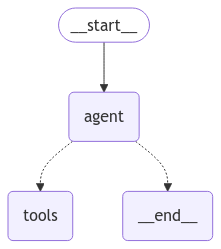

In [110]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [111]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='0932c00a-bf26-439e-a278-0ec7dfe22551'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_k2ch', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 941, 'total_tokens': 1022, 'completion_time': 0.147272727, 'prompt_time': 0.030218307, 'queue_time': 0.023226221, 'total_time': 0.177491034}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-854dd2bd-abc3-4733-83f3-b6a37ed2b267-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': 'call_k2ch', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 81, 'total_tokens': 1022}),
  ToolMessage(content="It's 40*C degrees and scootching heat.", name='search', id='8dea279e-12ed-43c7-a

In [112]:
app.invoke({"messages": ["what is the weather in ca?"]})

{'messages': [HumanMessage(content='what is the weather in ca?', additional_kwargs={}, response_metadata={}, id='575ade2d-7209-44ba-944d-3eb4bf5f0a42'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5rzx', 'function': {'arguments': '{"query":"weather in ca"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 943, 'total_tokens': 1023, 'completion_time': 0.145454545, 'prompt_time': 0.030685466, 'queue_time': 0.024357283, 'total_time': 0.176140011}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bcf306ed-ee27-486b-b410-035b4e32bf46-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in ca'}, 'id': 'call_5rzx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 80, 'total_tokens': 1023}),
  ToolMessage(content="It's 20*C degrees and Cold.", name='search', id='a6d3a8bc-d643-472e-ade

In [113]:
#create loop by adding another edge
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [114]:
#Compile the workflow again
app = workflow.compile()

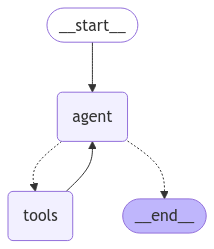

In [115]:
#Visualize the workflow
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [117]:
for output in app.stream({"messages": ["what is the weather in California?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g2t2', 'function': {'arguments': '{"query":"weather in California"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.039127358, 'queue_time': 0.026034931999999997, 'total_time': 0.188218267}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdb90ba4-25d3-4d6e-808a-baa95ba8a682-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in California'}, 'id': 'call_g2t2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 20*C degrees and Cold.", name='search', id='ebd059db-bc13-4ec5-8692-7cdaa84407b7', tool_call_id='ca

In [118]:
#Add Memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [119]:
#workflow
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model1)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [120]:
#While compile i pass the Checkpointer along with memory object
app3 = workflow3.compile(checkpointer = memory)

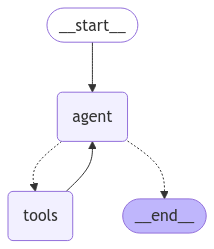

In [121]:
#Visualize the workflow
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [122]:
config = {"configurable": {"thread_id": "1"}} #thread id 1 indicates that single conversation.

#Capture the entire conversation in the memory if i shutdown the workstation then again i can start the conversation from where i left.
#That will be my thread 2 and the conversation will be stored in the thread 2.

In [123]:
events = app3.stream(
    {"messages": ["Hi there! My name is Amar."]}, config, stream_mode="values"
)

In [124]:
#output in the form of stream
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Amar.
================================== Ai Message ==================================
Tool Calls:
  search (call_j8mf)
 Call ID: call_j8mf
  Args:
    query: Hi there! My name is Amar.
================================= Tool Message =================================
Name: search

It's 40*C degrees and scootching heat.
================================== Ai Message ==================================
Tool Calls:
  search (call_a20s)
 Call ID: call_a20s
  Args:
    query: What is the weather like?
================================= Tool Message =================================
Name: search

It's 40*C degrees and scootching heat.
================================== Ai Message ==================================

It's 40*C degrees and scootching heat.


In [125]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [126]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Amar


In [127]:
#memory check
memory.get(config)

{'v': 1,
 'ts': '2025-01-24T12:52:15.048038+00:00',
 'id': '1efda520-9547-6dff-8008-00a36aa9c107',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Amar.', additional_kwargs={}, response_metadata={}, id='08c05fb1-9587-433f-9c73-46a8d6d86816'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j8mf', 'function': {'arguments': '{"query":"Hi there! My name is Amar."}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 944, 'total_tokens': 1030, 'completion_time': 0.156363636, 'prompt_time': 0.030163064, 'queue_time': 0.024051916000000003, 'total_time': 0.1865267}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-64785eb8-0bb6-49c0-9068-5681007cefec-0', tool_calls=[{'name': 'search', 'args': {'query': 'Hi there! My name is Amar.'}, 'id': 'call_j8mf', 'type': 'tool_call'}], usage_metadata={'input_t